In [1]:
# Imports - these are all the imports needed for the assignment
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import nltk package 
#   PennTreeBank word tokenizer 
#   English language stopwords
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

In [2]:
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /home/q/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /home/q/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
from nltk.tokenize import word_tokenize

### Imports

In [4]:
inspections_filepath = "inspections.csv"
inspections_df = pd.read_csv(inspections_filepath)

restaurants_filepath = "restaurants.csv"
restaurants_df = pd.read_csv(restaurants_filepath, dtype={
    "hsisid": str,
    "postal_code": str,
})

violations_filepath = "violations.csv"
violations_df = pd.read_csv(violations_filepath, dtype={
    "hsisid": str,
    "comments": str,
})

yelp_filepath = "yelp.csv"
yelp_df = pd.read_csv(yelp_filepath, dtype={
    "zip_code": str
})

zipcodes_filepath = "zipcodes.csv"
zipcodes_df = pd.read_csv(zipcodes_filepath)

#### Converters

In [5]:
def convert_restaurant_names(name_in):
        
    # Make the input all lowercase
    name_in = name_in.lower()
    
    # Drop all whitespace
    name_in = name_in.strip()
    
    # Chain restaurants have are of format 'chain name #NUMBER'
    # Remove '#NUMBER' is present
    hash_index = name_in.find('#')
    if hash_index != -1:
        name_in = name_in[0:hash_index]
        
    name_in = name_in.replace("i pre-security", "")
    name_in = name_in.replace("&amp;", "and")
    name_in = name_in.replace("&", "and")
        
    if "subway" in name_in:
        name_in = "subway"
    elif "mcdonald's" in name_in or "mcdonalds" in name_in:
        name_in = "mcdonald's"
    elif "starbuck" in name_in:
        name_in = "starbuck"
    elif "dunkin donuts" in name_in:
        name_in = "dunkin donuts"
    elif "arby's" in name_in:
        name_in = "arby's"
    elif "jersey mike" in name_in:
        name_in = "jersey mike"
    elif "wendy's" in name_in:
        name_in = "wendy's"
    elif "jamba j" in name_in:
        name_in = "jamba juice"
    elif "culver" in name_in:
        name_in = "culver's"
    elif "einstein" in name_in and "bagel" in name_in:
        name_in = "einstein bros bagel"
    elif "whataburger" in name_in:
        name_in = "whataburger"
    elif "church's chicken" in name_in:
        name_in = "church's hicken"
    elif "five guys" in name_in:
        name_in = "five guys"
    elif "chick-fil-a" in name_in:
        name_in = "chick-fil-a"
    elif "aubrey" in name_in and "peedi" in name_in and "grill" in name_in:
        name_in = "aubrey and peedies grill"
    elif "skipper's fish fry" in name_in or "skipper`s fish fry and market" == name_in:
        name_in = "skipper's fish fry"
    elif "dean's seafood grill" in name_in:
        name_in = "dean's seafood grill and bar"
    elif "salvio" in name_in and "pizzeria" in name_in:
        name_in = "salvio's pizzeria"
    elif "manchester" in name_in and "grill" in name_in:
        name_in = "manchester bar and grill"
    elif "sam" in name_in and "club" in name_in:
        name_in = "sam's club"
    elif "sami" in name_in and "pizza" in name_in and "more" in name_in:
        name_in = "sami's subs, pizza, and more"
        
    if name_in == "spring cafe 2":
        name_in = "spring cafe"
    
    return name_in.strip()

assert convert_restaurant_names("chick-fil-a #1573") == 'chick-fil-a'
assert convert_restaurant_names("taco bell #22798") == 'taco bell'
assert convert_restaurant_names("chick-fil-a of knightdale") == "chick-fil-a"

In [6]:
def convert_time(str_in):
    return pd.to_datetime(str_in)

In [7]:
def convert_zip(zipcode):
    
    # ZIP codes of form "AAAAA-BBBB" are specific version of "AAAAA"
    hyphen_index = zipcode.find('-')
    if hyphen_index != -1:
        zipcode = zipcode[0:hyphen_index]

    zipcode = zipcode.strip()
    return zipcode


assert convert_zip("12345") == "12345"
assert convert_zip("12345-678") == "12345"

In [8]:
restaurants_df_clean = restaurants_df.drop(labels=[
    "X.objectid",
    "name",
    "state",
    "address1",
    "address2",
    "city",
    "phonenumber",
    "geocodestatus",
    "x",
    "y",
    "facilitytype"
], axis="columns")

restaurants_df_clean.rename(columns={
    "hsisid": "id",
    "postalcode": 'zip',
    "restaurantopendate": "open_date"
}, inplace=True)

restaurants_df_clean = restaurants_df_clean[(restaurants_df["facilitytype"] == "Restaurant") 
                                            & (restaurants_df["facilitytype"] == "Restaurant")]
restaurants_df_clean["name"] = restaurants_df["name"].apply(convert_restaurant_names)
restaurants_df_clean["zip"] = restaurants_df_clean["zip"].apply(convert_zip)
restaurants_df_clean["open_date"] = restaurants_df_clean["open_date"].apply(convert_time)

restaurant_ids = restaurants_df_clean["id"]

restaurants_df_clean = restaurants_df_clean.reindex()
assert restaurants_df_clean["id"].is_unique == True

In [9]:
restaurants_df_clean.head()

,id,zip,open_date,name
0,4092017230,27616,2016-05-26 00:00:00+00:00,spring cafe
2,4092014444,27587,2005-12-05 00:00:00+00:00,taco bell
3,4092015333,27601,2009-02-04 00:00:00+00:00,the remedy diner
6,4092016679,27601,2014-04-23 00:00:00+00:00,bittersweet
7,4092014493,27617,2006-01-31 00:00:00+00:00,chick-fil-a


* **DATA IS FROM NORTH CAROLINA**
* Only care about restaurants ('facilitytype' in restaurants_df)
* Use 'hsisid' ('id') to ID locations and connect to violations
* Ignore address, name, phone number
* Yelp rating: 1-5 stars
* "Violations" with penalty = 0 are not actually violations but acknowledgements of good practice
* Many restaurants may be at same address
* Assuming yelp "rating" is the average across all reviews (treating it as a quantiative value), rounded to the nearest half
* Severity unknown meaning

In [10]:
violations_df_clean = violations_df.drop(labels=[
    "X.objectid",
    "statecode",
    "questionno",
    "violationcode",
    "inspectedby",
    "cdcriskfactor",
    "cdcdataitem",
    "violationtype",
    "observationtype",
    "count",
    "category",
    "shortdesc",
    "severity",
    "critical",
], axis="columns")
    
violations_df_clean.rename(columns={
    "hsisid": "id",
    "pointvalue": "penalty",
    "inspectdate": "inspect_date",
}, inplace=True)

violations_df_clean["inspect_date"] = violations_df_clean["inspect_date"].apply(convert_time)
violations_df_clean.drop_duplicates(inplace=True)
violations_df_clean = violations_df_clean.reindex()

In [11]:
violations_df_clean.head()

,id,inspect_date,comments,penalty
0,4092015279,2014-09-22 00:00:00+00:00,7-102.11; Priority Foundation - Found unlabele...,0
1,4092014572,2014-09-29 00:00:00+00:00,7-102.11; Priority Foundation; One sanitizer b...,0
2,4092015906,2014-10-01 00:00:00+00:00,7-102.11; Priority Foundation - Found an unlab...,1
3,4092013840,2014-10-08 00:00:00+00:00,7-102.11; Priority Foundation - Found unlabele...,0
4,4092021788,2014-10-09 00:00:00+00:00,7-102.11; Priority Foundation - Found one unla...,0


In [12]:
violations_df_clean["penalty"].value_counts()

0    130614
1     45019
2      4857
3      1020
4         6
Name: penalty, dtype: int64

In [13]:
violations_df_clean[violations_df_clean["penalty"] == 4]

,id,inspect_date,comments,penalty
57634,4092010071,2013-03-05 00:00:00+00:00,2-301.12 (C) TO avoid recontaminating their ha...,4
58414,4092012304,2012-12-06 00:00:00+00:00,P - 2-301.14 - Observed worker wash his hands ...,4
58478,4092013716,2013-02-21 00:00:00+00:00,2-301.14 An employee was observed scrubbing a...,4
67549,4092013070,2013-08-19 00:00:00+00:00,2-301.14; Priority; Employee working the gril...,4
69327,4092021677,2016-02-05 00:00:00+00:00,2-301.14; Priority; Employees must wash hands ...,4
162894,4092014362,2013-10-17 00:00:00+00:00,2-301.14; Priority; The cook handled raw chick...,4


In [14]:
yelp_df_clean = yelp_df.drop(labels=[
    "address1",
    "name",
    "price",
    "italian",
    "seafood",
    "newamerican",
    "chicken_wings",
    "delis",
    "bars",
    "salad",
    "seafood",
    "bbq",
    "bakeries",
    "sushi",
    "phone",
    "hotdogs",
    "sandwiches",
    "pizza",
    "tradamerican",
    "burgers",
    "mexican",
    "grocery",
    "breakfast_brunch",
    "coffee",
    "chinese",
    "latitude",
    "longitude",
    "price",
    "id",
    "is_closed",
], axis="columns")


yelp_df_clean.rename(columns={
    "id": "yelp_id",
    "zip_code": 'zip'
}, inplace=True)

yelp_df_clean["name"] = yelp_df["name"].apply(convert_restaurant_names)
yelp_df_clean["zip"] = yelp_df_clean["zip"].apply(convert_zip)

yelp_df_clean = yelp_df_clean[["zip", "name", "rating", "review_count"]]

In [15]:
yelp_df_clean.head()

,zip,name,rating,review_count
0,27560,42nd street oyster bar - rdu airport,2.5,23
1,27519,aldi foods,4.0,17
2,27612,luciano pizzeria ristorante,5.0,2
3,27893,olive garden italian restaurant,3.0,16
4,27896,subway,3.5,3


In [16]:
merged_df = restaurants_df_clean.merge(yelp_df_clean, how="left", left_on=["zip", "name"], right_on=["zip", "name"])
merged_df.dropna(axis="index", how="any", subset=["rating"], inplace=True)

merged_df = merged_df[["id", "zip", "open_date", "name", "rating", "review_count"]]

In [17]:
merged_df[merged_df["id"] == "4092015626"]

,id,zip,open_date,name,rating,review_count
1516,4092015626,27529,2010-04-27 00:00:00+00:00,mcdonald's,2.0,4.0
1517,4092015626,27529,2010-04-27 00:00:00+00:00,mcdonald's,2.5,3.0
1518,4092015626,27529,2010-04-27 00:00:00+00:00,mcdonald's,3.5,4.0
1519,4092015626,27529,2010-04-27 00:00:00+00:00,mcdonald's,2.0,2.0
1520,4092015626,27529,2010-04-27 00:00:00+00:00,mcdonald's,1.5,9.0


In [18]:
duplicates = merged_df[merged_df.duplicated(subset=["name", "zip"], keep=False)]
duplicates

,id,zip,open_date,name,rating,review_count
16,4092014233,27526,2005-01-26 00:00:00+00:00,sheetz,2.0,3.0
17,4092014233,27526,2005-01-26 00:00:00+00:00,sheetz,4.0,1.0
18,4092014233,27526,2005-01-26 00:00:00+00:00,sheetz,4.5,8.0
19,4092014269,27526,2005-02-10 00:00:00+00:00,subway,3.0,1.0
32,4092016069,27502,2011-12-15 00:00:00+00:00,subway,4.0,2.0
...,...,...,...,...,...,...
2428,4092015870,27616,2011-01-20 00:00:00+00:00,mcdonald's,3.0,1.0
2435,4092016557,27587,2013-10-31 00:00:00+00:00,burger king,3.0,3.0
2437,4092017274,27587,2016-06-24 00:00:00+00:00,harris teeter,3.0,10.0
2438,4092017274,27587,2016-06-24 00:00:00+00:00,harris teeter,3.5,9.0


In [19]:
merged_df[merged_df["id"] == "4092014233"]

,id,zip,open_date,name,rating,review_count
16,4092014233,27526,2005-01-26 00:00:00+00:00,sheetz,2.0,3.0
17,4092014233,27526,2005-01-26 00:00:00+00:00,sheetz,4.0,1.0
18,4092014233,27526,2005-01-26 00:00:00+00:00,sheetz,4.5,8.0


In [20]:
g = merged_df.groupby(by="id")
merged_df["weighted_rating"] = merged_df["review_count"] / g["review_count"].transform("sum") * merged_df["rating"]
merged_df.head()

,id,zip,open_date,name,rating,review_count,weighted_rating
0,4092017230,27616,2016-05-26 00:00:00+00:00,spring cafe,3.5,35.0,3.5
1,4092014444,27587,2005-12-05 00:00:00+00:00,taco bell,3.0,8.0,3.0
2,4092015333,27601,2009-02-04 00:00:00+00:00,the remedy diner,4.0,347.0,4.0
3,4092016679,27601,2014-04-23 00:00:00+00:00,bittersweet,4.0,150.0,4.0
4,4092014493,27617,2006-01-31 00:00:00+00:00,chick-fil-a,3.5,20.0,3.5


In [21]:
merged_df[merged_df["id"] == "4092014233"]

,id,zip,open_date,name,rating,review_count,weighted_rating
16,4092014233,27526,2005-01-26 00:00:00+00:00,sheetz,2.0,3.0,0.500000
17,4092014233,27526,2005-01-26 00:00:00+00:00,sheetz,4.0,1.0,0.333333
18,4092014233,27526,2005-01-26 00:00:00+00:00,sheetz,4.5,8.0,3.000000


In [114]:
merged_df.duplicated(subset="id").value_counts()

False    986
True     211
dtype: int64

In [22]:
merged_df['average_rating'] = merged_df.groupby(['id'])['weighted_rating'].transform('sum')

In [23]:
merged_df[merged_df["id"] == "4092014233"]

,id,zip,open_date,name,rating,review_count,weighted_rating,average_rating
16,4092014233,27526,2005-01-26 00:00:00+00:00,sheetz,2.0,3.0,0.500000,3.833333
17,4092014233,27526,2005-01-26 00:00:00+00:00,sheetz,4.0,1.0,0.333333,3.833333
18,4092014233,27526,2005-01-26 00:00:00+00:00,sheetz,4.5,8.0,3.000000,3.833333


In [24]:
deduped_merged_df = merged_df.drop_duplicates(subset="id")
deduped_merged_df["review_count"] = merged_df.groupby(['id'])["review_count"].transform('sum')
deduped_merged_df[deduped_merged_df["id"] == "4092014233"]
deduped_merged_df.drop(columns=["weighted_rating", "rating"], inplace=True)

assert deduped_merged_df["id"].is_unique == True

In [25]:
deduped_merged_df[deduped_merged_df["id"] == "4092014233"]

,id,zip,open_date,name,review_count,average_rating
16,4092014233,27526,2005-01-26 00:00:00+00:00,sheetz,12.0,3.833333


In [26]:
deduped_merged_df.head()

,id,zip,open_date,name,review_count,average_rating
0,4092017230,27616,2016-05-26 00:00:00+00:00,spring cafe,35.0,3.5
1,4092014444,27587,2005-12-05 00:00:00+00:00,taco bell,8.0,3.0
2,4092015333,27601,2009-02-04 00:00:00+00:00,the remedy diner,347.0,4.0
3,4092016679,27601,2014-04-23 00:00:00+00:00,bittersweet,150.0,4.0
4,4092014493,27617,2006-01-31 00:00:00+00:00,chick-fil-a,20.0,3.5


In [27]:
anonymous_df = deduped_merged_df.drop(labels=[
    "zip",
    "name",
], axis="columns")

In [28]:
anonymous_df.head()

,id,open_date,review_count,average_rating
0,4092017230,2016-05-26 00:00:00+00:00,35.0,3.5
1,4092014444,2005-12-05 00:00:00+00:00,8.0,3.0
2,4092015333,2009-02-04 00:00:00+00:00,347.0,4.0
3,4092016679,2014-04-23 00:00:00+00:00,150.0,4.0
4,4092014493,2006-01-31 00:00:00+00:00,20.0,3.5


In [29]:
violations_df_clean.head()

,id,inspect_date,comments,penalty
0,4092015279,2014-09-22 00:00:00+00:00,7-102.11; Priority Foundation - Found unlabele...,0
1,4092014572,2014-09-29 00:00:00+00:00,7-102.11; Priority Foundation; One sanitizer b...,0
2,4092015906,2014-10-01 00:00:00+00:00,7-102.11; Priority Foundation - Found an unlab...,1
3,4092013840,2014-10-08 00:00:00+00:00,7-102.11; Priority Foundation - Found unlabele...,0
4,4092021788,2014-10-09 00:00:00+00:00,7-102.11; Priority Foundation - Found one unla...,0


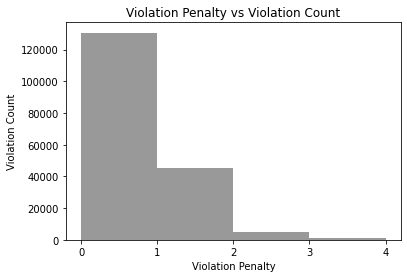

In [30]:
penalty_plot = sns.distplot(violations_df_clean["penalty"], bins=4, kde=False, color="black")
penalty_plot.set_xlabel("Violation Penalty")
penalty_plot.set_ylabel("Violation Count")
penalty_plot.set_title("Violation Penalty vs Violation Count")
penalty_plot.set_xticks([0, 1, 2, 3 ,4], minor=False);

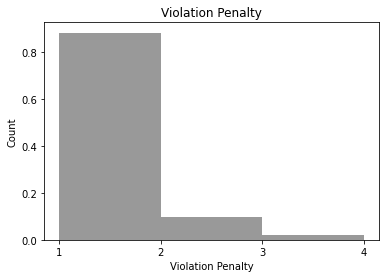

In [31]:
penalty_plot = sns.distplot(violations_df_clean[violations_df_clean["penalty"] > 0]["penalty"], bins=3, color="black")
penalty_plot.set_xlabel("Violation Penalty")
penalty_plot.set_ylabel("Count")
penalty_plot.set_title("Violation Penalty")
penalty_plot.set_xticks([1, 2, 3 ,4], minor=False);

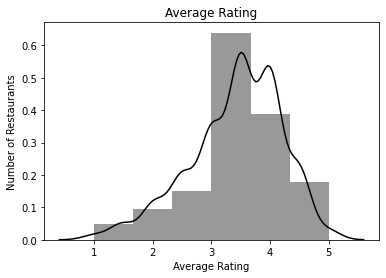

In [32]:
yelp_review_plot = sns.distplot(anonymous_df["average_rating"], bins=6, kde=True, color="black")
yelp_review_plot.set_xlabel("Average Rating")
yelp_review_plot.set_ylabel("Number of Restaurants")
yelp_review_plot.set_title("Average Rating")

yelp_review_plot;

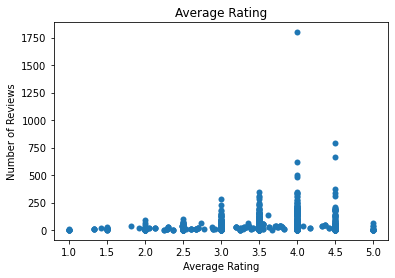

In [33]:
rating_review_count_plot = sns.scatterplot(x="average_rating", y="review_count", data=anonymous_df, linewidth=0)
rating_review_count_plot.set_xlabel("Average Rating")
rating_review_count_plot.set_ylabel("Number of Reviews");
rating_review_count_plot.set_title("Average Rating");

In [34]:
total_penalty = violations_df_clean.groupby(["id"]).sum()["penalty"]
penalty_count = violations_df_clean.groupby(["id"]).count()["penalty"]
average_penalty = violations_df_clean.groupby(["id"]).mean()["penalty"]

anonymous_penalty_df = anonymous_df.merge(total_penalty, on="id")
anonymous_penalty_df = anonymous_penalty_df.merge(penalty_count, on="id")
anonymous_penalty_df = anonymous_penalty_df.merge(average_penalty, on="id")


anonymous_penalty_df.rename(columns={
    "penalty_x": "total_penalty",
    "penalty_y": "penalty_count",
    "penalty": "average_penalty"
}, inplace=True)


anonymous_penalty_df

,id,open_date,review_count,average_rating,total_penalty,penalty_count,average_penalty
0,4092017230,2016-05-26 00:00:00+00:00,35.0,3.500000,10,24,0.416667
1,4092014444,2005-12-05 00:00:00+00:00,8.0,3.000000,9,57,0.157895
2,4092015333,2009-02-04 00:00:00+00:00,347.0,4.000000,27,80,0.337500
3,4092016679,2014-04-23 00:00:00+00:00,150.0,4.000000,1,14,0.071429
4,4092014493,2006-01-31 00:00:00+00:00,20.0,3.500000,14,44,0.318182
...,...,...,...,...,...,...,...
948,4092016368,2013-02-05 00:00:00+00:00,48.0,3.500000,58,121,0.479339
949,4092015461,2009-09-11 00:00:00+00:00,42.0,3.500000,20,49,0.408163
950,4092016658,2014-04-03 00:00:00+00:00,24.0,4.000000,22,53,0.415094
951,4092016557,2013-10-31 00:00:00+00:00,3.0,3.000000,15,35,0.428571


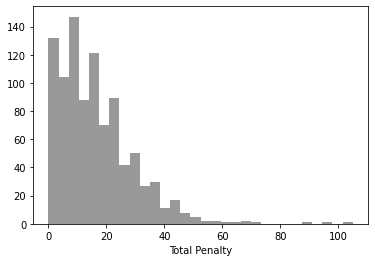

In [35]:
total_penalty_plot = sns.distplot(anonymous_penalty_df["total_penalty"], bins=30, kde=False, color="black")
total_penalty_plot.set_xlabel("Total Penalty")

total_penalty_plot;

In [36]:
anonymous_penalty_df[anonymous_penalty_df["total_penalty"] > 50]

,id,open_date,review_count,average_rating,total_penalty,penalty_count,average_penalty
45,4092016005,2011-09-20 00:00:00+00:00,35.0,3.0,55,137,0.401460
64,4092014399,2005-10-07 00:00:00+00:00,61.0,3.0,69,174,0.396552
96,4092015939,2011-04-20 00:00:00+00:00,115.0,3.5,68,188,0.361702
127,4092015445,2009-08-20 00:00:00+00:00,27.0,3.0,52,102,0.509804
240,4092015891,2011-02-18 00:00:00+00:00,224.0,3.5,71,177,0.401130
320,4092013966,2004-01-02 00:00:00+00:00,5.0,3.0,95,301,0.315615
426,4092013977,2004-01-30 00:00:00+00:00,12.0,3.0,55,99,0.555556
580,4092015755,2011-06-17 00:00:00+00:00,70.0,3.5,61,146,0.417808
735,4092016681,2014-04-24 00:00:00+00:00,13.0,3.0,89,175,0.508571
788,4092016598,2014-01-06 00:00:00+00:00,33.0,3.5,56,168,0.333333


In [37]:
violations_df_clean[violations_df_clean["id"] =="4092015115"].sort_values(axis="index", by="inspect_date")

,id,inspect_date,comments,penalty
166221,4092015115,2012-10-22 00:00:00+00:00,3-307.11 Do not place pans or plastic contain...,0
150173,4092015115,2012-10-22 00:00:00+00:00,6-501.12 Clean floors and walls in kitchen.,0
167135,4092015115,2012-10-22 00:00:00+00:00,3-304.14 Store wiping clothes used for wiping ...,0
168771,4092015115,2012-10-22 00:00:00+00:00,3-304.12 Do not store knives between equipment...,1
170095,4092015115,2012-10-22 00:00:00+00:00,4-903.11 (A) Clean linens and cloths shall be ...,0
...,...,...,...,...
183640,4092015115,2016-07-25 00:00:00+00:00,4-501.16; Core; Chicken stored on clean side d...,0
98885,4092015115,2016-07-25 00:00:00+00:00,4-903.11(A) and (B); Core; Linens may not be d...,0
130288,4092015115,2016-07-25 00:00:00+00:00,4-205.10; Core; Chest freezer and server stati...,1
116683,4092015115,2016-07-25 00:00:00+00:00,4-601.11 (A); Priority Foundation; Prep sinks ...,1


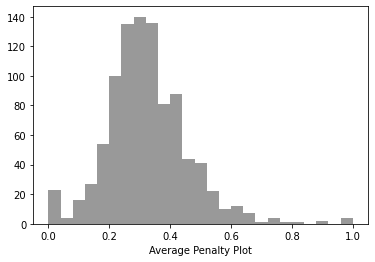

In [38]:
average_penalty_plot = sns.distplot(anonymous_penalty_df["average_penalty"], bins=25, kde=False, color="black")
average_penalty_plot.set_xlabel("Average Penalty Plot")

average_penalty_plot;

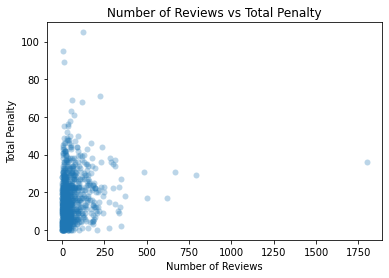

In [72]:
penalty_review_count_plot = sns.scatterplot(x="review_count", y="total_penalty", data=anonymous_penalty_df, linewidth=0, alpha=0.3)
penalty_review_count_plot.set_ylabel("Total Penalty")
penalty_review_count_plot.set_xlabel("Number of Reviews");
penalty_review_count_plot.set_title("Number of Reviews vs Total Penalty");

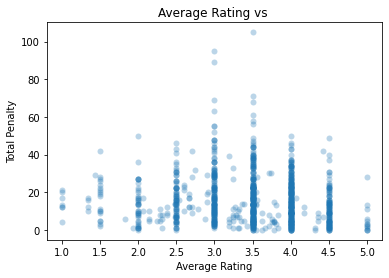

In [73]:
penalty_rating_plot = sns.scatterplot(x="average_rating", y="total_penalty", data=anonymous_penalty_df, linewidth=0, alpha=0.3)
penalty_rating_plot.set_xlabel("Average Rating");
penalty_rating_plot.set_ylabel("Total Penalty")
penalty_rating_plot.set_title("Average Rating vs ");

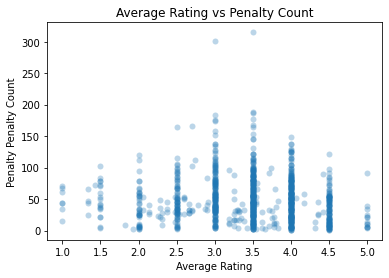

In [74]:
penalty_count_rating_plot = sns.scatterplot(x="average_rating", y="penalty_count", data=anonymous_penalty_df, linewidth=0, alpha=0.3)
penalty_count_rating_plot.set_xlabel("Average Rating");
penalty_count_rating_plot.set_ylabel("Penalty Penalty Count")
penalty_count_rating_plot.set_title("Average Rating vs Penalty Count");

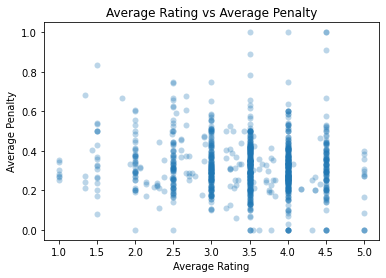

In [75]:
penalty_mean_rating_mean_plot = sns.scatterplot(x="average_rating", y="average_penalty", data=anonymous_penalty_df, linewidth=0, alpha=0.3)
penalty_mean_rating_mean_plot.set_xlabel("Average Rating");
penalty_mean_rating_mean_plot.set_ylabel("Average Penalty")
penalty_mean_rating_mean_plot.set_title("Average Rating vs Average Penalty");

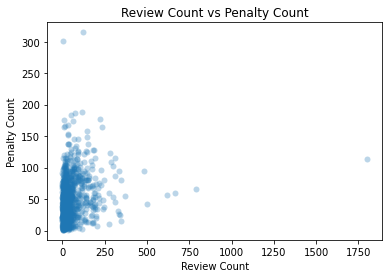

In [76]:
review_count_rating_plot = sns.scatterplot(x="review_count", y="penalty_count", data=anonymous_penalty_df, linewidth=0, alpha=0.3)
review_count_rating_plot.set_ylabel("Penalty Count");
review_count_rating_plot.set_xlabel("Review Count")
review_count_rating_plot.set_title("Review Count vs Penalty Count");

### Sentiment analysis on violation comment

In [44]:
violations_df_clean.head()

,id,inspect_date,comments,penalty
0,4092015279,2014-09-22 00:00:00+00:00,7-102.11; Priority Foundation - Found unlabele...,0
1,4092014572,2014-09-29 00:00:00+00:00,7-102.11; Priority Foundation; One sanitizer b...,0
2,4092015906,2014-10-01 00:00:00+00:00,7-102.11; Priority Foundation - Found an unlab...,1
3,4092013840,2014-10-08 00:00:00+00:00,7-102.11; Priority Foundation - Found unlabele...,0
4,4092021788,2014-10-09 00:00:00+00:00,7-102.11; Priority Foundation - Found one unla...,0


In [45]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
analyser = SentimentIntensityAnalyzer()

In [46]:
def sentiment_analysis(str_input):
    if pd.isna(str_input):
        return np.nan
    score = analyser.polarity_scores(str_input)
    return score["compound"]

In [47]:
violations_df_clean["comment_sentiment"] = violations_df_clean["comments"].apply(sentiment_analysis)

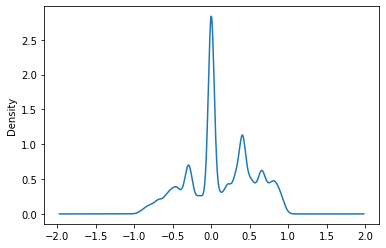

In [48]:
violations_df_clean[violations_df_clean["comments"].isna() == False]['comment_sentiment'].plot.density(label='most')

In [49]:
violations_df_clean[(violations_df_clean["comment_sentiment"] > 0.0) & (violations_df_clean["penalty"] == 4.0)]

,id,inspect_date,comments,penalty,comment_sentiment
162894,4092014362,2013-10-17 00:00:00+00:00,2-301.14; Priority; The cook handled raw chick...,4,0.8225


In [50]:
violations_df_clean.loc[162894].comments

"2-301.14; Priority; The cook handled raw chicken, and shrimp  with gloved hands on three different occasions and then went on to touch clean plates without washing his hands. Employee's must wash hands after switching between raw FOODS and touching clean utensil. Employees must also wash their hands after doing activities that will contaminate their hands. CDI... The employee removed his gloves and wash his hand properly each occasion."

In [51]:
violations_df_clean["comment_sentiment"]

0        -0.2960
1         0.0000
2         0.0387
3         0.0000
4         0.0000
           ...  
189792   -0.5023
189794    0.0000
189796    0.0000
189799    0.7378
189800    0.0000
Name: comment_sentiment, Length: 181516, dtype: float64

In [52]:
violations_df_clean[(violations_df_clean["penalty"] == 3) & (violations_df_clean["comment_sentiment"] > 0.5)]

,id,inspect_date,comments,penalty,comment_sentiment
7247,4092030128,2016-06-29 00:00:00+00:00,"2-201.11 (A), (B), (C), and (E); Employee able...",3,0.5023
42590,4092014578,2012-12-20 00:00:00+00:00,P - 3-501.14 - Container of beans 49F after co...,3,0.6249
42756,4092015187,2014-10-03 00:00:00+00:00,3-501.14; Priority; Plastic Bus Tub Full of Fr...,3,0.7964
43990,4092016372,2013-10-29 00:00:00+00:00,3-501.16(A)(1) ; Priority;Cooked shrimp and ve...,3,0.6249
44118,4092110035,2014-02-10 00:00:00+00:00,3-501.16(A)(1) ; Priority;Maintain quesadillas...,3,0.7351
...,...,...,...,...,...
177391,4092016852,2016-02-01 00:00:00+00:00,4-601.11 (A) . The clean dishes have food resi...,3,0.8689
177401,4092021692,2016-02-05 00:00:00+00:00,4-601.11 (A); Priority Foundation; None of the...,3,0.8519
177412,4092016617,2016-02-18 00:00:00+00:00,4-601.11 (A); Priority Foundation; REQUIRES TH...,3,0.5319
177489,4092015991,2016-04-21 00:00:00+00:00,4-601.11 (A); Priority Foundation; The lettuce...,3,0.9246


In [53]:
violations_df_clean.loc[177391].comments

'4-601.11 (A) . The clean dishes have food residue, and some feel sticky. Clean the dishes thoroughly. Check them before they are placed on the clean dish storage racks. (A) EQUIPMENT FOOD-CONTACT SURFACES and UTENSILS shall be clean to sight and touch.'

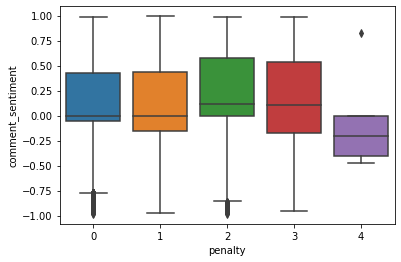

In [54]:
penalty_sentiment_plot = sns.boxplot(data=violations_df_clean[violations_df_clean["comments"].isna() == False], x='penalty', y='comment_sentiment')

In [55]:
violations_df_clean[(violations_df_clean["penalty"] == 3) & (violations_df_clean["comment_sentiment"] >= 0.25)]

,id,inspect_date,comments,penalty,comment_sentiment
6753,4092021443,2015-03-03 00:00:00+00:00,2-103.11 (M); An employee health policy is req...,3,0.3818
7247,4092030128,2016-06-29 00:00:00+00:00,"2-201.11 (A), (B), (C), and (E); Employee able...",3,0.5023
7326,4092015955,2016-01-05 00:00:00+00:00,"2-201.11 (A), (B), (C), and (E); Core; Person ...",3,0.3612
42590,4092014578,2012-12-20 00:00:00+00:00,P - 3-501.14 - Container of beans 49F after co...,3,0.6249
42756,4092015187,2014-10-03 00:00:00+00:00,3-501.14; Priority; Plastic Bus Tub Full of Fr...,3,0.7964
...,...,...,...,...,...
177391,4092016852,2016-02-01 00:00:00+00:00,4-601.11 (A) . The clean dishes have food resi...,3,0.8689
177401,4092021692,2016-02-05 00:00:00+00:00,4-601.11 (A); Priority Foundation; None of the...,3,0.8519
177412,4092016617,2016-02-18 00:00:00+00:00,4-601.11 (A); Priority Foundation; REQUIRES TH...,3,0.5319
177489,4092015991,2016-04-21 00:00:00+00:00,4-601.11 (A); Priority Foundation; The lettuce...,3,0.9246


In [56]:
violations_df_clean.loc[42590].comments

'P - 3-501.14 - Container of beans 49F after cooling 23 hours in reach in cooler, and pan of rice 93F after cooling 4.5 hours. Potentially hazardous food must cool 135-70F within two hours and to 45F or less within a total of six hours. Manager discarded beans and reheated rice. Check food during cooling at least hourly to ensure it meets required parameters; recommend making cooling log to practice.'

In [67]:
outcome_1, predictors_1 = patsy.dmatrices("average_penalty ~ average_rating", anonymous_penalty_df[["average_penalty", "average_rating"]])

mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()

In [68]:
res_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        average_penalty   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     6.952
Date:                Mon, 08 Jun 2020   Prob (F-statistic):            0.00851
Time:                        02:30:49   Log-Likelihood:                 550.63
No. Observations:                 953   AIC:                            -1097.
Df Residuals:                     951   BIC:                            -1088.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.3759      0.020     18.651      0.000       0.336       0.416
average_rating    -0.0151      0.006     -2.637      0.009      -0.026      -0.004
==============================================================================
Omnibus:                      171.389   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              541.431
Skew:                           0.873   Prob(JB):                    2.69e-118
Kurtosis:                       6.254   Cond. No.                         17.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

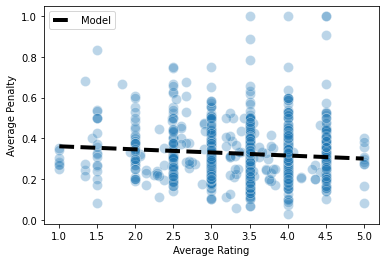

In [111]:
sns.scatterplot(x='average_rating', y='average_penalty', alpha=0.3, data=anonymous_penalty_df, s=100)

# Generate and plot the model fit line
xs = np.arange(anonymous_penalty_df['average_rating'].min(), 6)
ys = -0.0151 * xs + 0.37596
plt.plot(xs, ys, '--k', linewidth=4, label='Model')

plt.xlabel('Average Rating')
plt.ylabel('Average Penalty')
plt.legend();

In [88]:
average_penalty_adjusted = violations_df_clean[violations_df_clean["penalty"] > 0].groupby(["id"]).mean()

anonymous_penalty_df = anonymous_penalty_df.merge(average_penalty_adjusted, on="id")

anonymous_penalty_df.rename(columns={
    "penalty": "adjusted_average_penalty"
}, inplace=True)

In [89]:
anonymous_penalty_df.head()

,id,open_date,review_count,average_rating,total_penalty,penalty_count,average_penalty,adjusted_average_penalty,comment_sentiment
0,4092017230,2016-05-26 00:00:00+00:00,35.0,3.5,10,24,0.416667,1.000000,0.199040
1,4092014444,2005-12-05 00:00:00+00:00,8.0,3.0,9,57,0.157895,1.285714,0.462786
2,4092015333,2009-02-04 00:00:00+00:00,347.0,4.0,27,80,0.337500,1.227273,0.037105
3,4092016679,2014-04-23 00:00:00+00:00,150.0,4.0,1,14,0.071429,1.000000,-0.800100
4,4092014493,2006-01-31 00:00:00+00:00,20.0,3.5,14,44,0.318182,1.076923,-0.100162


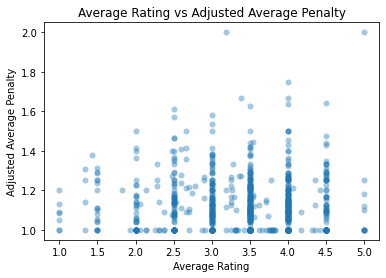

In [95]:
penalty_mean_rating_mean_plot = sns.scatterplot(x="average_rating", y="adjusted_average_penalty", data=anonymous_penalty_df, linewidth=0, alpha=0.4)
penalty_mean_rating_mean_plot.set_xlabel("Average Rating");
penalty_mean_rating_mean_plot.set_ylabel("Adjusted Average Penalty")
penalty_mean_rating_mean_plot.set_title("Average Rating vs Adjusted Average Penalty");

In [103]:
outcome_2, predictors_2 = patsy.dmatrices("adjusted_average_penalty ~ average_rating", anonymous_penalty_df[["adjusted_average_penalty", "average_rating"]])

mod_2 = sm.OLS(outcome_2, predictors_2)
res_2 = mod_2.fit()

In [104]:
res_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     adjusted_average_penalty   R-squared:                       0.004
Model:                                  OLS   Adj. R-squared:                  0.003
Method:                       Least Squares   F-statistic:                     3.721
Date:                      Mon, 08 Jun 2020   Prob (F-statistic):             0.0540
Time:                              02:43:31   Log-Likelihood:                 541.54
No. Observations:                       931   AIC:                            -1079.
Df Residuals:                           929   BIC:                            -1069.
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.1517      0.020     56.650      0.000       1.112       1.192
average_rating    -0.0112      0.006     -1.929      0.054      -0.023       0.000
==============================================================================
Omnibus:                      370.142   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1672.432
Skew:                           1.823   Prob(JB):                         0.00
Kurtosis:                       8.461   Cond. No.                         17.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

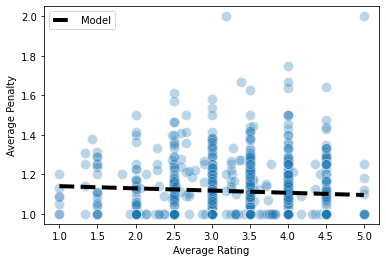

In [110]:
sns.scatterplot(x='average_rating', y='adjusted_average_penalty', alpha=0.3, data=anonymous_penalty_df, s=100)

# Generate and plot the model fit line
xs = np.arange(anonymous_penalty_df['average_rating'].min(), 6)
ys = -0.0112 * xs + 1.1517 
plt.plot(xs, ys, '--k', linewidth=4, label='Model')

plt.xlabel('Average Rating')
plt.ylabel('Average Penalty')
plt.legend();

In [115]:
cat_merged = merged_df.drop_duplicates(subset="id")

In [118]:
cat_merged["rating"].value_counts()

4.0    267
3.5    242
3.0    162
4.5    105
2.5     94
2.0     54
1.5     29
5.0     20
1.0     13
Name: rating, dtype: int64

In [123]:
violations_df_clean[violations_df_clean['inspect_date'].dt.year == 2016]

,id,inspect_date,comments,penalty,comment_sentiment
109,4092016765,2016-04-04 00:00:00+00:00,7-102.11; Priority Foundation - Found an unlab...,0,0.0000
158,4092017117,2016-01-05 00:00:00+00:00,7-102.11; Priority Foundation; four chemical b...,1,0.3182
191,4092011518,2016-01-12 00:00:00+00:00,7-102.11; Priority Foundation; one chemical bo...,0,0.3182
192,4092010585,2016-01-15 00:00:00+00:00,7-102.11; Priority Foundation; one chemical bo...,0,0.3182
193,4092017078,2016-01-15 00:00:00+00:00,7-102.11; Priority Foundation; REQUIRES THE C...,1,0.0000
...,...,...,...,...,...
188860,4092017134,2016-04-14 00:00:00+00:00,3-202.12 ; Priority; Bottle of mustard oil i...,0,-0.0258
188881,4092017197,2016-06-27 00:00:00+00:00,7-101.11; Priority Foundation; Spray bottle o...,1,-0.1779
188882,4092011268,2016-08-24 00:00:00+00:00,7-101.11; Priority Foundation; One bottle of v...,0,0.0000
188883,4092015006,2016-10-13 00:00:00+00:00,7-101.11; Priority Foundation; Chemical spray...,1,0.0000
